In [223]:
import math
import numpy as np

from bloqade import rydberg_h, piecewise_linear, piecewise_constant, waveform, cast
from bloqade.atom_arrangement import ListOfLocations, Lieb, Square, Chain, Honeycomb, Kagome, Triangular, Rectangular
from bokeh.io import output_notebook # to plot "show()" on the notebook, without opening a browser
import os
import matplotlib.pyplot as plt

import pickle
import time

from scipy.signal import convolve2d
from pathlib import Path
import os
import re

output_notebook()

Loading BokehJS ...

In [224]:
def circle_kernel(radius):
    kernel_size = int(np.floor(radius))*2+1
    kernel = np.zeros((kernel_size, kernel_size))
    
    for i in range(kernel_size):
        for j in range(kernel_size):
            if (radius)**2 >= (i-int(radius))**2+(j-int(radius))**2:
                kernel[i][j] = 1
    kernel[int(radius)][int(radius)] = 0
    return kernel


def is_independent(arr, kernel, radius, return_missed=True):
    kernel_sum = np.sum(kernel)
    padded = np.pad(arr, int(radius), constant_values=1)
    convolved = convolve2d(padded, kernel, mode="valid")

    # print(arr)
    # print(convolved)
    # print((convolved[np.bitwise_not(arr.astype(bool))] == kernel_sum).astype(int))
    # print()
    is_independent = np.all(convolved[np.bitwise_not(arr.astype(bool))] == kernel_sum)

    if return_missed:
        return is_independent, ((convolved == kernel_sum) ^ arr).astype(bool)
    else: 
        return is_independent

In [225]:
def independent_set_probabilities(save_path):
    data = {}
    for pickle_file in list(Path(f"{save_path}/").glob('*.pickle')):
        with pickle_file.open('rb') as file: sweep_data = pickle.load(file)
        # step = int(''.join(re.findall(r'\d', pickle_file.stem)))
        data[sweep_data["d_max"]]= {}
        
        radius = sweep_data["unit_disk"]["unit_disc_radius"]
        kernel = circle_kernel(radius)
        x_size, y_size = sweep_data["unit_disk"]["lattice_dimension"]
        arrays = sweep_data["bitstrings"][0]

        unique, counts = np.unique(arrays, axis=0, return_counts=True)
        
        indep_sets_idx = []
        cardininalities = []
        for i, array in list(enumerate(unique)):
            if is_independent(array.reshape(x_size, y_size), kernel, radius, return_missed=False):
                indep_sets_idx.append(i)
                cardininalities.append(array.size - np.sum(array))

        indep_sets_idx = np.array(indep_sets_idx)[np.argsort(cardininalities)]
        cardininalities = np.array(np.sort(cardininalities))

        prob = []
        for c in np.unique(cardininalities):
            fixed_card = indep_sets_idx[np.where(cardininalities==c)]
            prob.append(np.sum(counts[fixed_card])/np.sum(counts))

        data[sweep_data["d_max"]]["prob"] = prob[::-1]
        data[sweep_data["d_max"]]["cardinality"] = np.unique(cardininalities)[::-1]

    with open(f'{save_path}/indep_set_probabilities.data', 'wb') as file:
        pickle.dump(data, file)

In [228]:
def plot_set_probabilites(save_path, title):
    with Path(f"{save_path}/indep_set_probabilities.data").open('rb') as file: 
        data = pickle.load(file)
        print(data)

    fig = plt.figure(figsize=(10,7), dpi=150)
    ax = fig.add_subplot(111, projection='3d')

    width = 0.8
    depth = (max(data.keys()) - min(data.keys()))/len(data)*0.8/2/np.pi
    colors = plt.cm.plasma(np.linspace(0, 1, len(data)))

    for i, (y, details) in enumerate(sorted(data.items(), key = lambda x: x[0])):
        xs = details['cardinality']
        ys = np.full(len(xs), y/2/np.pi)  
        # ys = [str(round(y/2/np.pi,2)) for _ in xs]
        print(ys)
        z = details['prob']
        
        ax.bar3d(xs-width/2, ys-depth/2, np.zeros(len(xs)), width, depth, z, color = colors[i], alpha=0.6, cmap="viridis")

    ax.set_xlabel('Cardinality', labelpad=10)
    ax.set_ylabel('Delta [Mhz]', labelpad=10)
    ax.set_zlabel('Probability')
    ax.set_yticklabels([round(x/2/np.pi, 2) for x in sorted(data.keys())])
    ax.set_yticks([round(x/2/np.pi, 2) for x in sorted(data.keys())])


    ax.set_title(title)

    plt.show()

{0.7527743848299554: {'prob': [0.01, 0.42, 0.45, 0.05], 'cardinality': array([3, 2, 1, 0])}, 0.5031585391045794: {'prob': [0.47, 0.35, 0.1], 'cardinality': array([2, 1, 0])}, 1.1262241031714617: {'prob': [0.01, 0.51, 0.31, 0.02], 'cardinality': array([3, 2, 1, 0])}, 1.6849414062499994: {'prob': [0.03, 0.41, 0.23, 0.01], 'cardinality': array([3, 2, 1, 0])}, 0.6154387538548323: {'prob': [0.01, 0.35, 0.43, 0.11], 'cardinality': array([3, 2, 1, 0])}, 0.41136264801025374: {'prob': [0.26, 0.45, 0.21], 'cardinality': array([2, 1, 0])}, 0.9207565674191878: {'prob': [0.03, 0.46, 0.25, 0.1], 'cardinality': array([3, 2, 1, 0])}, 1.3775418774579475: {'prob': [0.02, 0.43, 0.28, 0.03], 'cardinality': array([3, 2, 1, 0])}}
[0.0654704 0.0654704 0.0654704]
[0.08008017 0.08008017 0.08008017]
[0.09795012 0.09795012 0.09795012 0.09795012]
[0.11980776 0.11980776 0.11980776 0.11980776]
[0.14654296 0.14654296 0.14654296 0.14654296]
[0.17924413 0.17924413 0.17924413 0.17924413]
[0.2192426 0.2192426 0.2192426 

/var/folders/pk/c370vj0d1dxftbfzz9b9v6vc0000gn/T/ipykernel_51470/2285351817.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([round(x/2/np.pi, 2) for x in sorted(data.keys())])


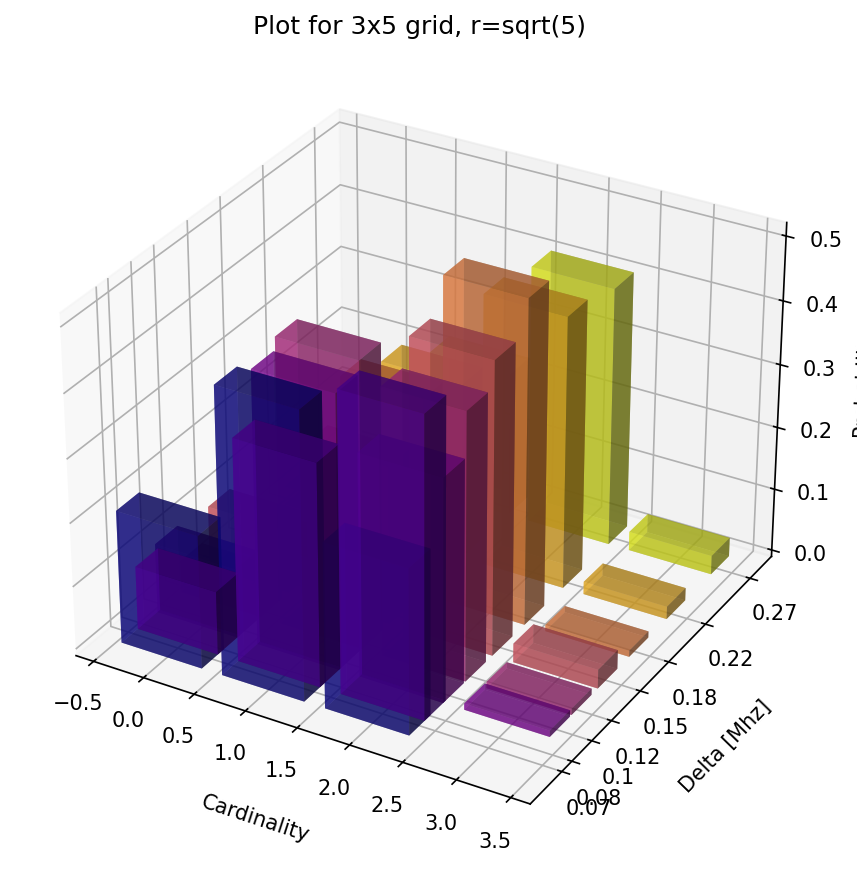

In [229]:
independent_set_probabilities("run3_grid_3x5_sqrt5")
plot_set_probabilites("run3_grid_3x5_sqrt5", "Plot for 3x5 grid, r=sqrt(5)")